<a href="https://colab.research.google.com/github/jvcm/intelivix_data_science/blob/master/ped_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.1)


In [0]:
from google.colab import files

In [4]:
uploaded = files.upload()

Saving test.tsv to test.tsv
Saving train.tsv to train.tsv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import keras

Using TensorFlow backend.


# Desafio P&D 2

## 1) Pré processamento dos dados

Os dados a serem processados se encontram na pasta 'dados' e possuem formato .tsv (Tab Separated Values).

In [0]:
df_train = pd.read_csv('train.tsv', delimiter='\t')
df_test = pd.read_csv('test.tsv', delimiter='\t')

In [7]:
df_train.head(10)

,Id,IdSentenca,Texto,Sentimento
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


Com auxílio do módulo <i>re</i> (<i>Regular expressions</i>) foi possível pré processar os dados textuais do <i>DataFrame</i>. Todos os sinais de pontuação foram removidos e as letras em maiúsculo foram substituídas pelas respectivas letras em minúsculo.

In [0]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_text(text):
    text = [REPLACE_NO_SPACE.sub("", line.lower()) for line in text]
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]

    return text

In [0]:
df_train.Texto = preprocess_text(df_train.Texto)
df_test.Texto = preprocess_text(df_test.Texto)

Nota-se pelo cabeçalho do DataFrame que as alterações foram realizadas com sucesso.

In [10]:
df_train.head(10)

,Id,IdSentenca,Texto,Sentimento
0,1,1,a series of escapades demonstrating the adage ...,1
1,2,1,a series of escapades demonstrating the adage ...,2
2,3,1,a series,2
3,4,1,a,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


## 2) Extração de atributos

In [11]:
cv = CountVectorizer(binary=True)
cv.fit(df_train.Texto)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
X = cv.transform(df_train.Texto)
y = df_train.Sentimento.values
y = y.astype('str')

## 3) Análise dos dados

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Quantidade de dados por classe')

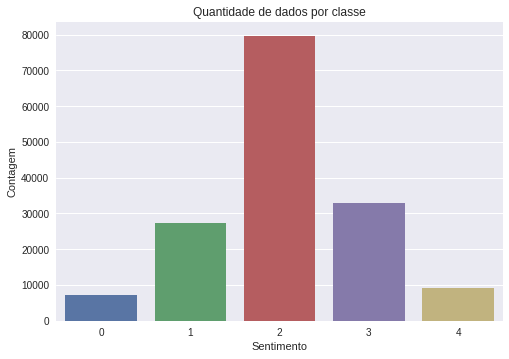

In [28]:
sns.countplot(y)
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.title('Quantidade de dados por classe')

O gráfico acima indica um alto desbalanceamento para as classes extremas. Isso ocorre em partes porque foram extraídos trechos de cada <i>review</i>, de modo que mais objetos da classe <i>neutro</i> fossem criados. Desta forma, os dados das classes "centrais" serão classificadas com maior facilidade, visto que qualquer frase desconexa será encaixada em uma delas.<br><br>
A seguir os dados são particionados em conjunto de treinamento e validação. Como os nomes sugerem, o primeiro conjunto servirá para treinar os classificadores propostos e o segundo avaliará o desempenho dos modelos.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [0]:
X_test = cv.transform(df_test.Texto)

## 4) Classificação

Serão utilizados 3 classificadores: regressão logística, <i>random subspace</i> e CNN. Nos dois primeirso classificadores, foi realizado um <i>gridsearch</i> em um parâmetro específico de modo que se obtenha a melhor configuração testada em um conjunto de validação. Como verificado acima, a base de dados é desbalanceada nas classes extremas (<i>negativo</i> e <i>positivo</i>). Por este motivo, o <i>classification report</i> também será exibido para análise mais detalhada.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

### Logistic Regression

O modelo de regressão logística, comparado a outros modelos, é mais fácil de ser interpretado e de aprendizagem mais rápida. Além de que modelos lineares tendem a performar bem em bases de dados dispersas. O parâmetro <i>C</i> explorado representa um coeficiente de regularização, utilizado para reduzir os efeitos de <i>overfitting</i> durante a aprendizagem.

In [17]:
aux_score = np.Inf
for c in [0.05, 0.25, 0.5, 1, 1.25]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    if score < aux_score:
        best_pred = y_pred[:]
        best_c = c
        best_lr = lr
print ("C = %s - Accuracy: %.3f" % (best_c, accuracy_score(y_val, best_pred)))
print('Classification report:\n',classification_report(y_val, best_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


C = 1.25 - Accuracy: 0.642
Classification report:
               precision    recall  f1-score   support

           0       0.53      0.29      0.37      1410
           1       0.56      0.38      0.45      5527
           2       0.68      0.89      0.77     15957
           3       0.59      0.43      0.50      6516
           4       0.59      0.34      0.43      1802

   micro avg       0.64      0.64      0.64     31212
   macro avg       0.59      0.46      0.50     31212
weighted avg       0.63      0.64      0.62     31212



### Random subspace

Para problemas de classificação em que exista o problema de alta dimensionalidade (grande quantidade de atributos), uma técnica bastante utilizada é o <i>Random Subspace</i>. O método consiste em coletar subconjuntos de mesmo tamanho do conjunto original, porém, com o número de atributos reduzido e de forma aleatória. O parâmetro  <i>max_features</i> explorado indica a proporção de atributos do conjunto original que serão selecionados para formar o novo subconjunto.<br><br>
Logo, para cada subconjunto será treinado um classificador (árvore de decisão). No final do processo, será obtido um <i>ensemble</i> de 20 classificadores.

In [18]:
aux_score = np.Inf
for max_ in [0.5, 0.6, 0.7]:
    bag = BaggingClassifier(n_estimators=20, max_features=max_, max_samples=1.0)
    bag.fit(X_train, y_train)
    y_pred = bag.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    if score < aux_score:
        best_pred = y_pred[:]
        best_max = max_
        best_bag = bag
print ("Max_feature = %s - Accuracy: %.3f" % (best_max, accuracy_score(y_val, best_pred)))
print('Classification report:\n',classification_report(y_val, best_pred))

Max_feature = 0.7 - Accuracy: 0.641
Classification report:
               precision    recall  f1-score   support

           0       0.48      0.36      0.41      1410
           1       0.56      0.44      0.49      5527
           2       0.70      0.83      0.76     15957
           3       0.57      0.49      0.52      6516
           4       0.51      0.39      0.44      1802

   micro avg       0.64      0.64      0.64     31212
   macro avg       0.56      0.50      0.53     31212
weighted avg       0.63      0.64      0.63     31212



### Deep learning

Para bases de dados consideradas grandes e com alta dimensionalidade, é interessante encontrar modelos de aprendizagem com uma quantidade adequada de parâmetros para serem ajustados. Por este motivo, foi escolhido como o terceiro modelo uma rede neural profunda conhecida por <i>Convolutional Neural Network</i>. A rede construída possui 3 camadas, onde a primeira possui 500 neurônios, a segunda possui 200 neurônios e por fim a última camada de saída possui os 4 neurônios responsável pela classificação. A função de ativação dos neurônios nas camadas intermediárias é <i>relu</i>, enquanto a função dos neurônios de saída é a função sigmóide.

In [0]:
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense

In [20]:
enc = OneHotEncoder()
enc.fit(y.reshape(-1,1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [0]:
y_train_ = enc.transform(y_train.reshape(-1,1))

In [0]:
model = Sequential()
model.add(Dense(500, input_dim=X.shape[1], activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(5, activation='sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.fit(X_train, y_train_, epochs=70, batch_size=10)

Epoch 1/70
124848/124848 [==============================] - 194s 2ms/step - loss: 0.3201 - acc: 0.8556
Epoch 2/70
124848/124848 [==============================] - 201s 2ms/step - loss: 0.2568 - acc: 0.8856
Epoch 3/70
124848/124848 [==============================] - 204s 2ms/step - loss: 0.2196 - acc: 0.9031
Epoch 4/70
124848/124848 [==============================] - 200s 2ms/step - loss: 0.1923 - acc: 0.9152
Epoch 5/70
124848/124848 [==============================] - 205s 2ms/step - loss: 0.1702 - acc: 0.9242
Epoch 6/70
124848/124848 [==============================] - 195s 2ms/step - loss: 0.1523 - acc: 0.9326
Epoch 7/70
124848/124848 [==============================] - 199s 2ms/step - loss: 0.1379 - acc: 0.9387
Epoch 8/70
124848/124848 [==============================] - 203s 2ms/step - loss: 0.1264 - acc: 0.9446
Epoch 9/70
124848/124848 [==============================] - 204s 2ms/step - loss: 0.1174 - acc: 0.9483
Epoch 10/70
124848/124848 [==============================] - 201s 2ms/ste

In [0]:
y_val_ = enc.transform(y_val.reshape(-1,1))

In [0]:
y_pred = model.predict(X_val)

In [36]:
score, acc = model.evaluate(X_val, y_val_,
                            batch_size=10)
print('Test accuracy:', acc)

31212/31212 [==============================] - 13s 424us/step
Test accuracy: 0.849474561591798


In [0]:
cnn_prediction = enc.inverse_transform(y_pred.round()).T[0].astype(int)

In [61]:
cnn_prediction

array([3, 4, 3, ..., 2, 2, 3])

In [62]:
print(classification_report(y_val, cnn_prediction.astype(str)))

              precision    recall  f1-score   support

           0       0.22      0.45      0.29      1410
           1       0.52      0.47      0.50      5527
           2       0.74      0.73      0.73     15957
           3       0.54      0.52      0.53      6516
           4       0.51      0.38      0.44      1802

   micro avg       0.60      0.60      0.60     31212
   macro avg       0.51      0.51      0.50     31212
weighted avg       0.62      0.60      0.61     31212



## 5) Test.csv

Visto que as classes do conjunto <i>test.csv</i> não estão disponíveis para avaliar os modelos, foram geradas as saídas dos classificadores para todas as instâncias do <i>data set</i> de teste. Desta forma, os avaliadores poderão comparar as respostas geradas dos modelos com as verdadeiras classes.

In [0]:
saidas = pd.DataFrame()
saidas['Logistic_regression'] = lr.predict(X_test)
saidas['Random_subspace'] = bag.predict(X_test)
saidas['CNN'] = enc.inverse_transform(model.predict(X_test).round()).T[0].astype(int)

In [0]:
saidas.to_csv('models_output.csv')